In [1]:
import numpy as np
import uproot
import matplotlib.pyplot as plt
from scipy import integrate
import AnaUtils as au
import Triggered as tr

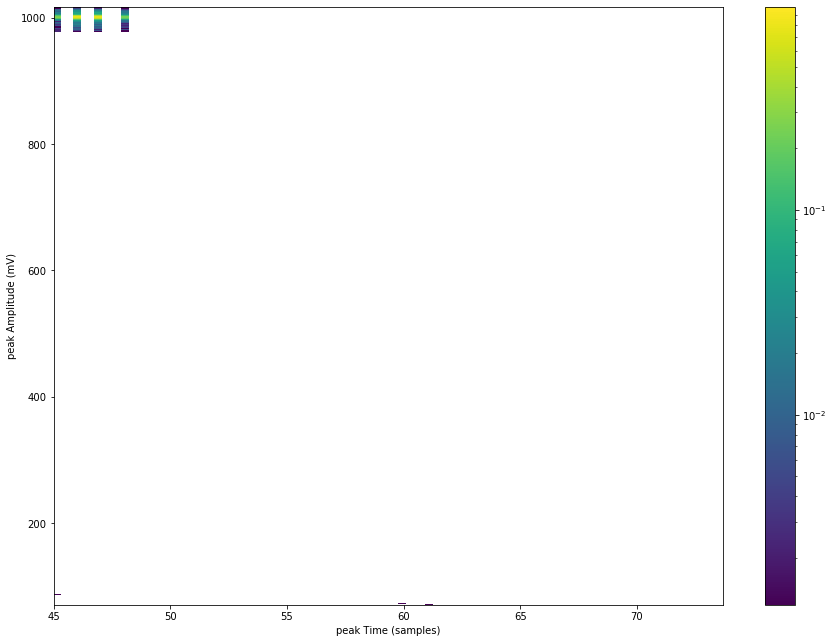

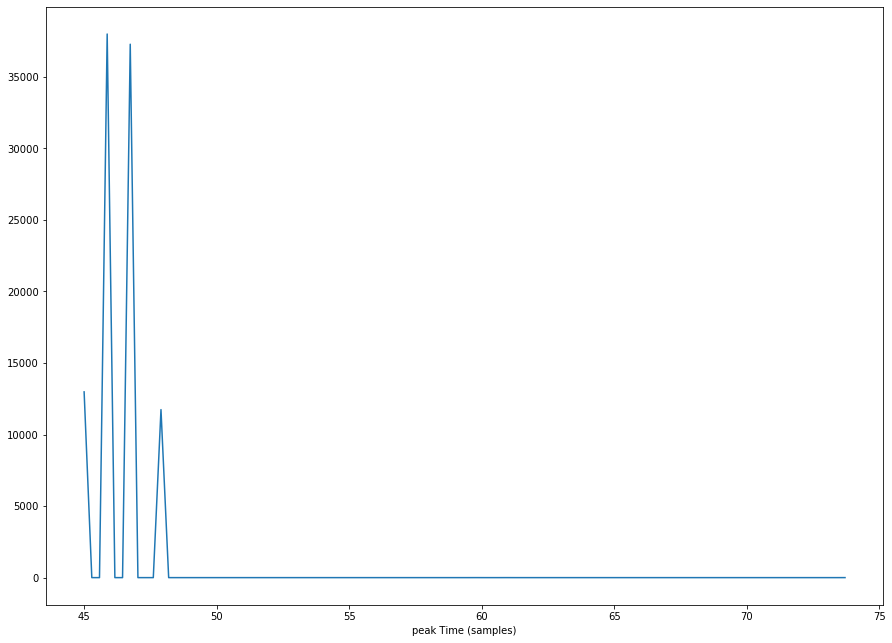

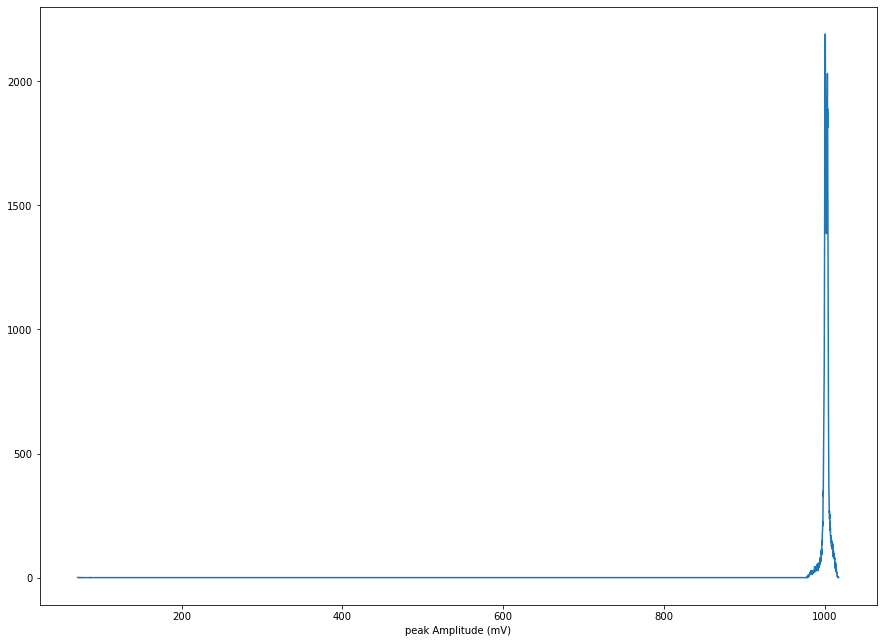

Text(0, 0.5, 'Rate [Hz]')

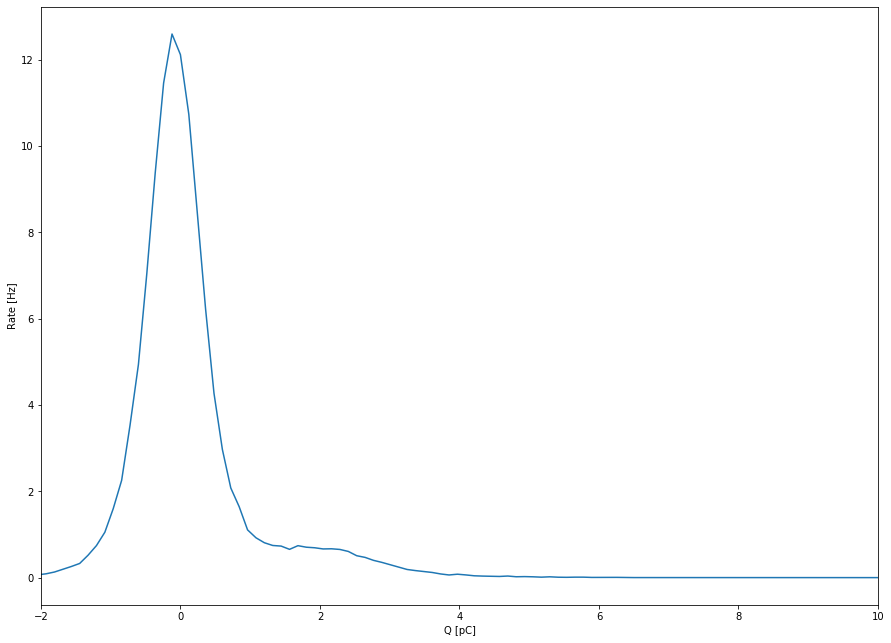

In [2]:
QSPE = tr.extRun('/data/share/SA5446/SPE2_1710V_200617_100_samples_100000_events/0',30,10,30,qbins=1000)
plt.plot(QSPE[1],QSPE[0])
#plt.yscale('log')
plt.xlim(-2,10)
plt.xlabel('Q [pC]')
plt.ylabel('Rate [Hz]')

In [4]:
GFit = tr.fitQ(QSPE,[0,12,1,2,1,1],([-1,2,0,0.5,0,0],[1,15,2.5,3,3,3.5]))
GFit
SPE1710 = GFit[0][4]

In [5]:
wdir = '/data/share/SA5446'
Gains = [1202,1299,1399,1500,1602,1710,1800,1901]
fWaves = ['{}/Gain_{}V_200617_100_samples_20000_events/0'.format(wdir,iG) for iG in Gains]
fWaves

['/data/share/SA5446/Gain_1202V_200617_100_samples_20000_events/0',
 '/data/share/SA5446/Gain_1299V_200617_100_samples_20000_events/0',
 '/data/share/SA5446/Gain_1399V_200617_100_samples_20000_events/0',
 '/data/share/SA5446/Gain_1500V_200617_100_samples_20000_events/0',
 '/data/share/SA5446/Gain_1602V_200617_100_samples_20000_events/0',
 '/data/share/SA5446/Gain_1710V_200617_100_samples_20000_events/0',
 '/data/share/SA5446/Gain_1800V_200617_100_samples_20000_events/0',
 '/data/share/SA5446/Gain_1901V_200617_100_samples_20000_events/0']

In [6]:
nBins = [50,50,50,50,50]
P0 = [[0.5,300,0.5],[0.7,300,1,2.1,1,1],[1.5,300,2,3.2,10,2],[2,200,3,6,10,2],[0,150,0.2,4,250,4,10,10,4]]

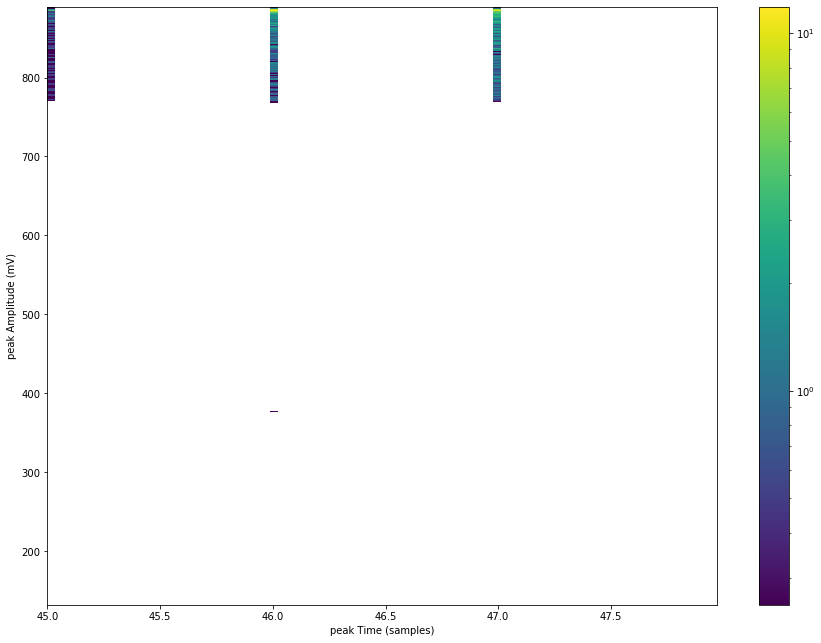

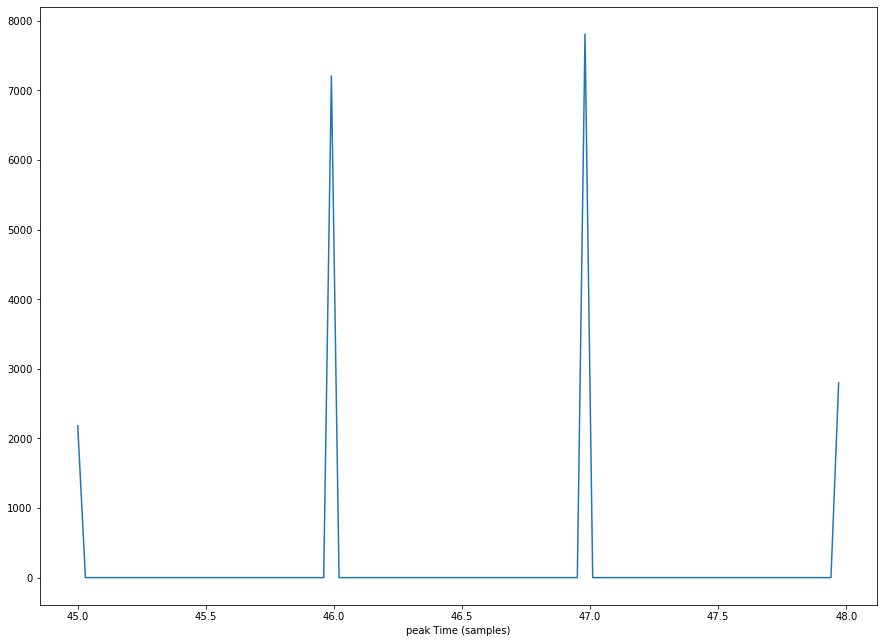

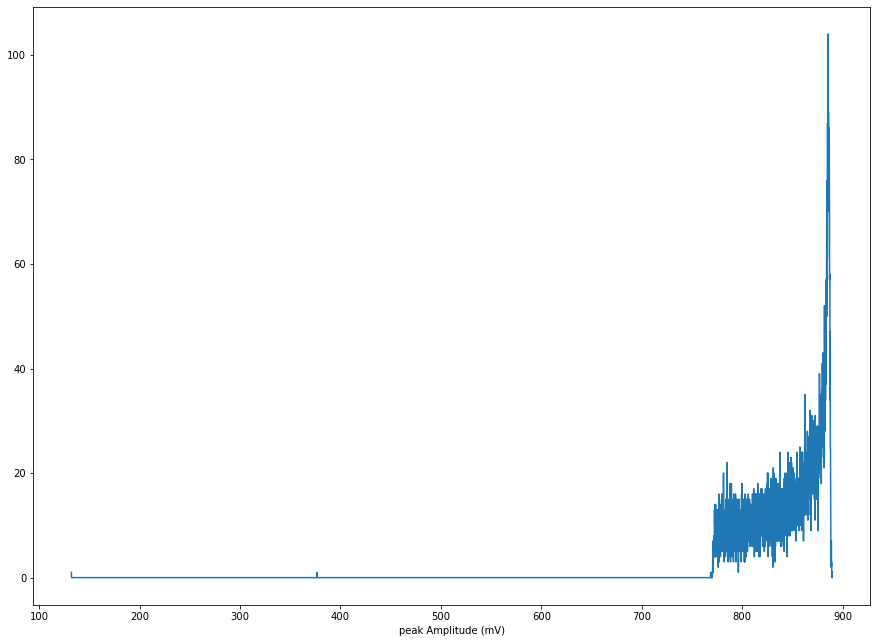

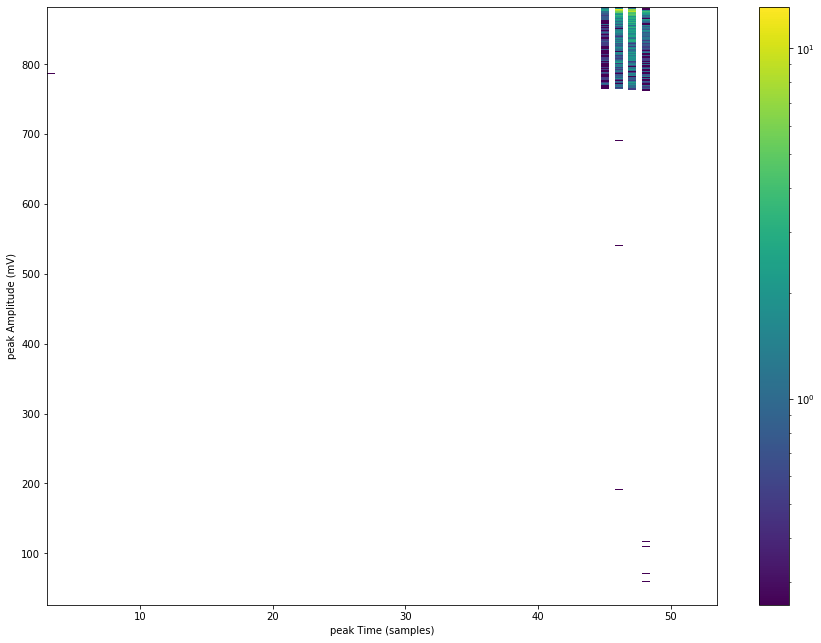

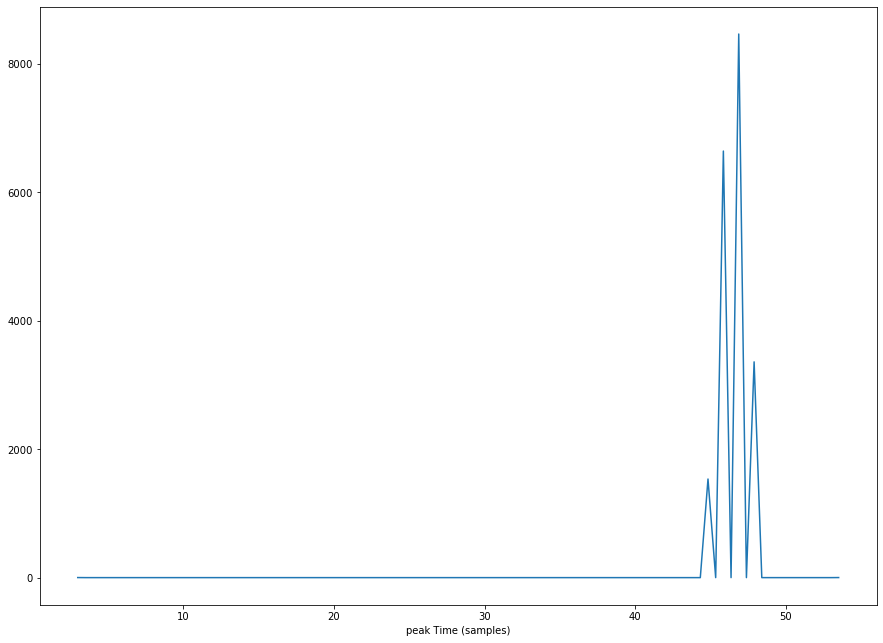

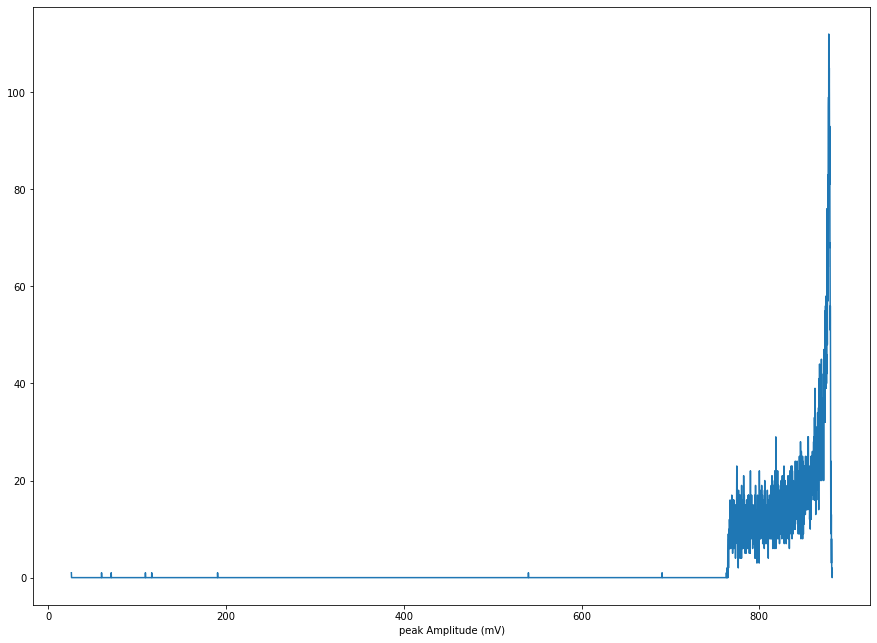

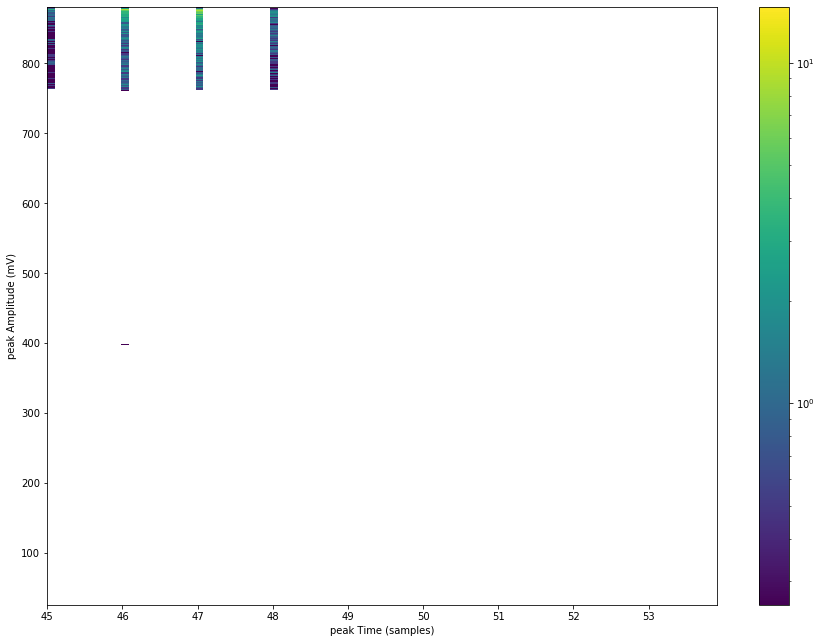

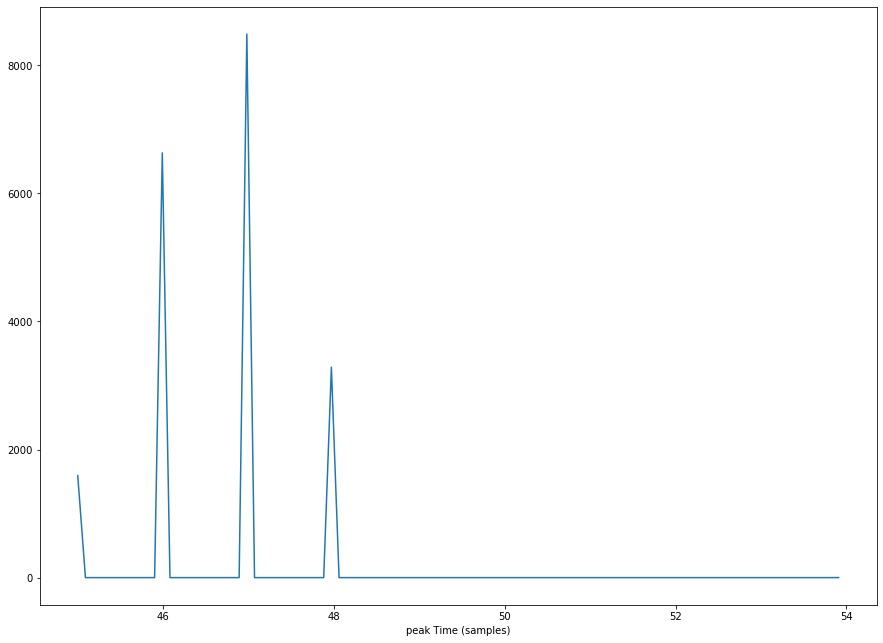

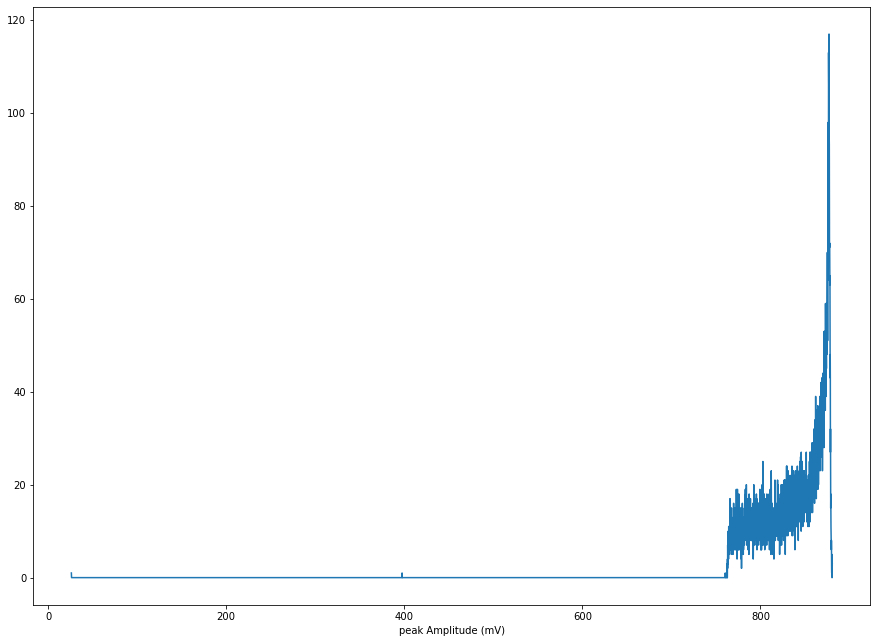

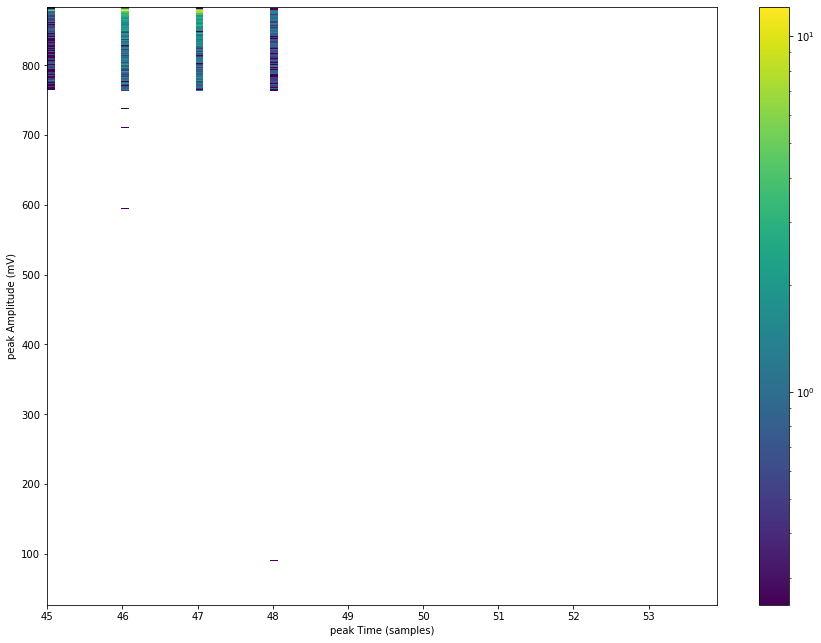

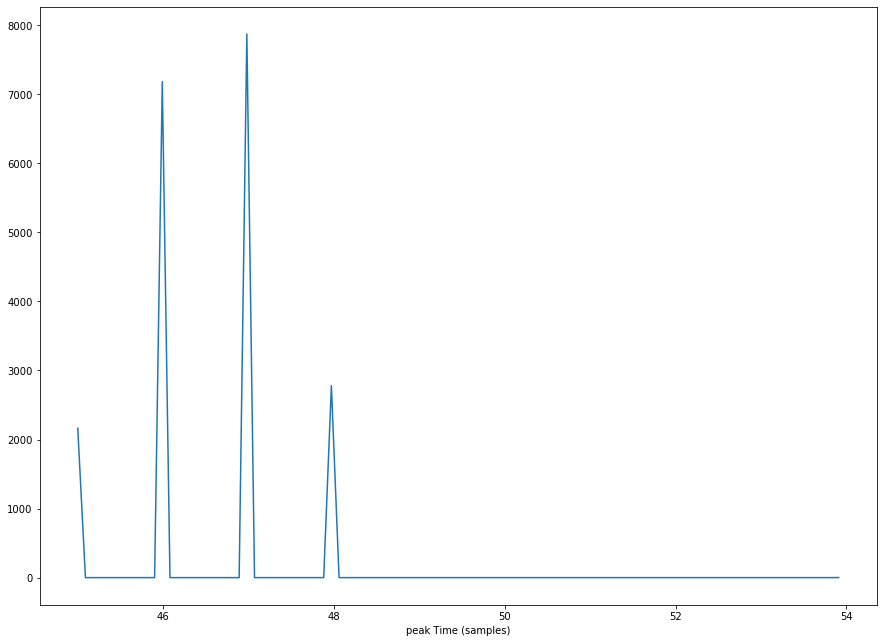

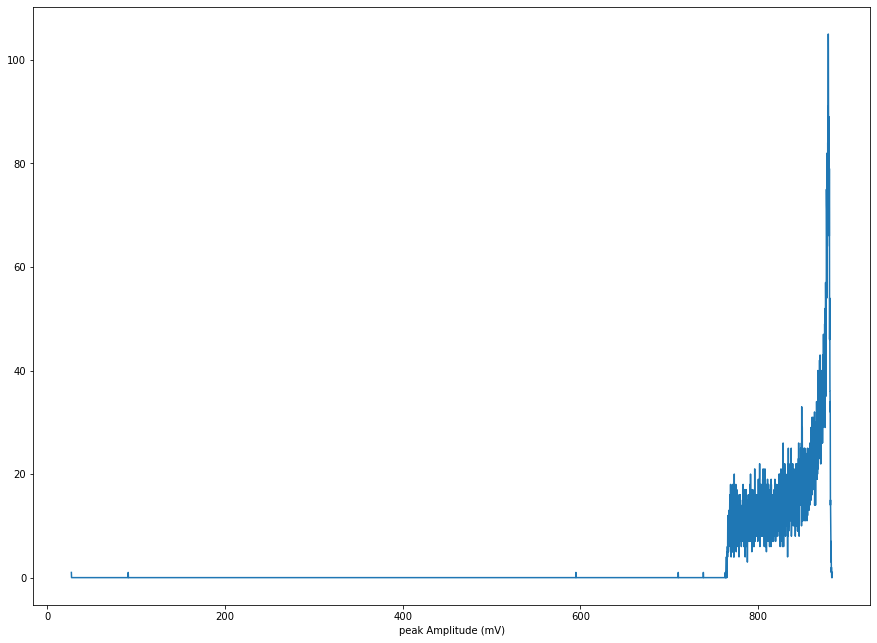

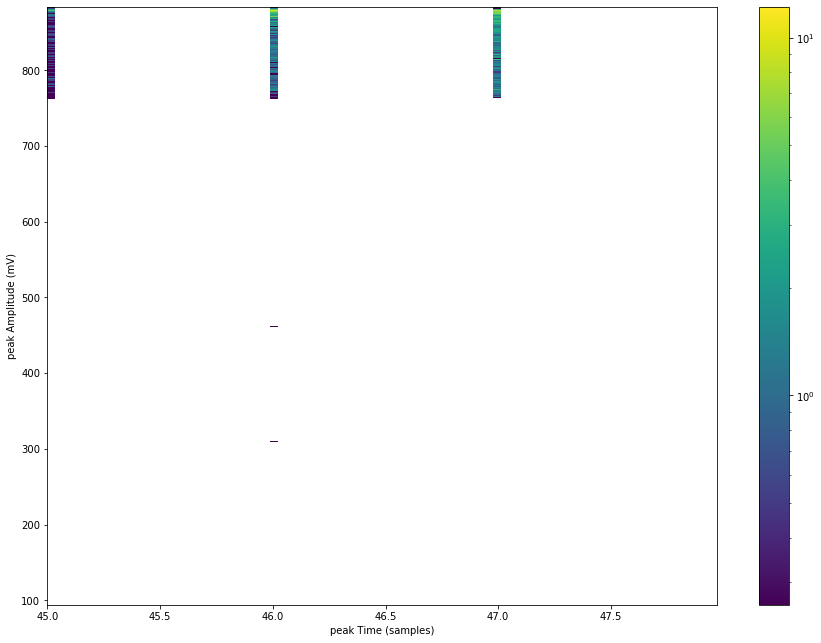

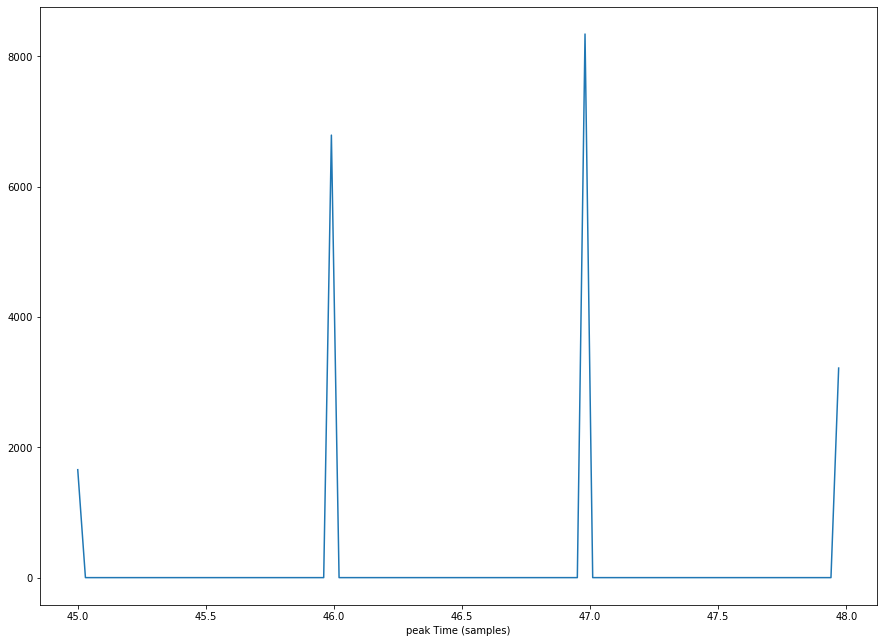

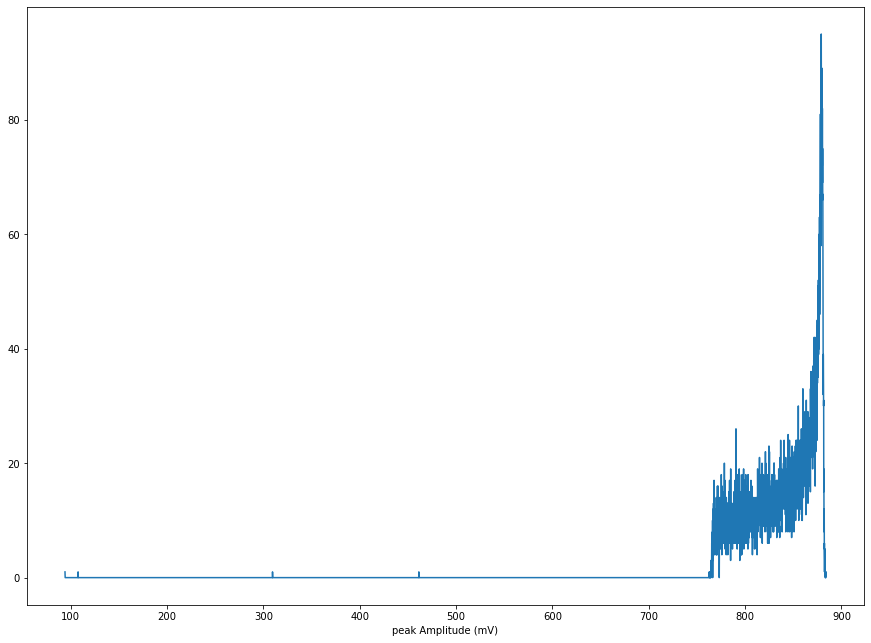

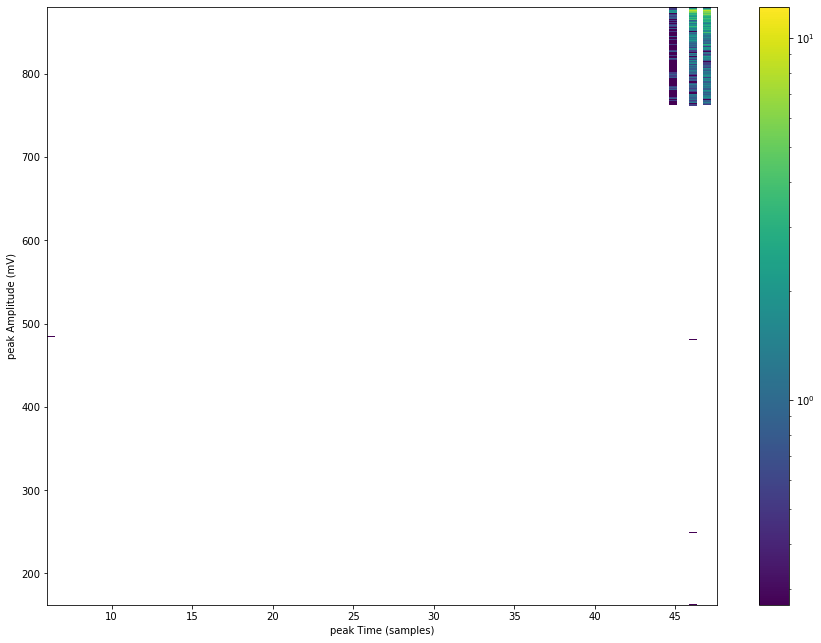

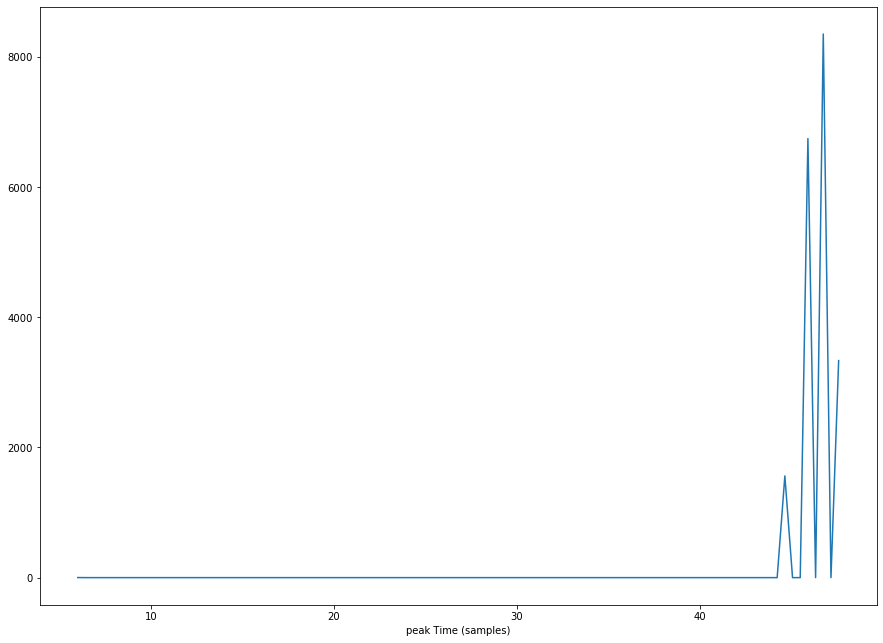

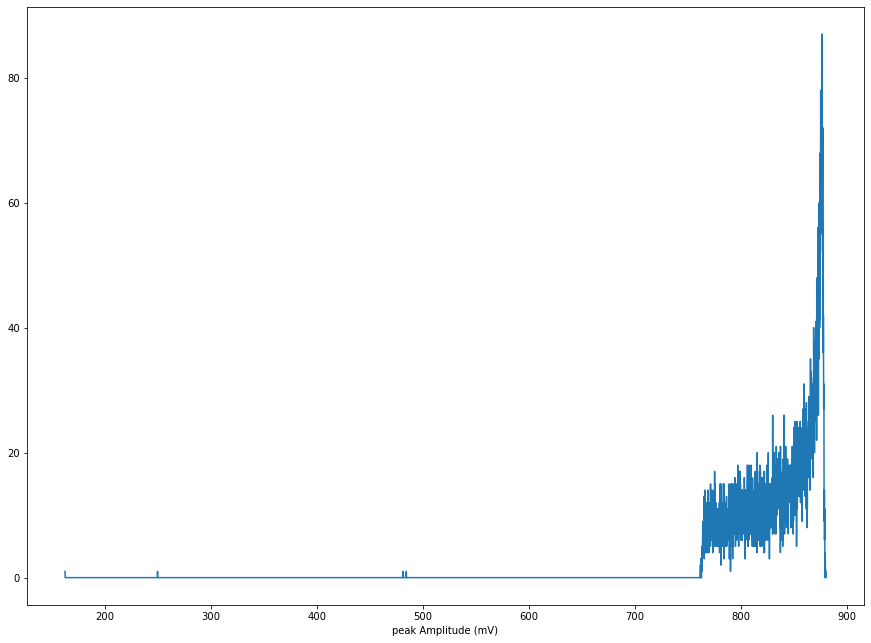

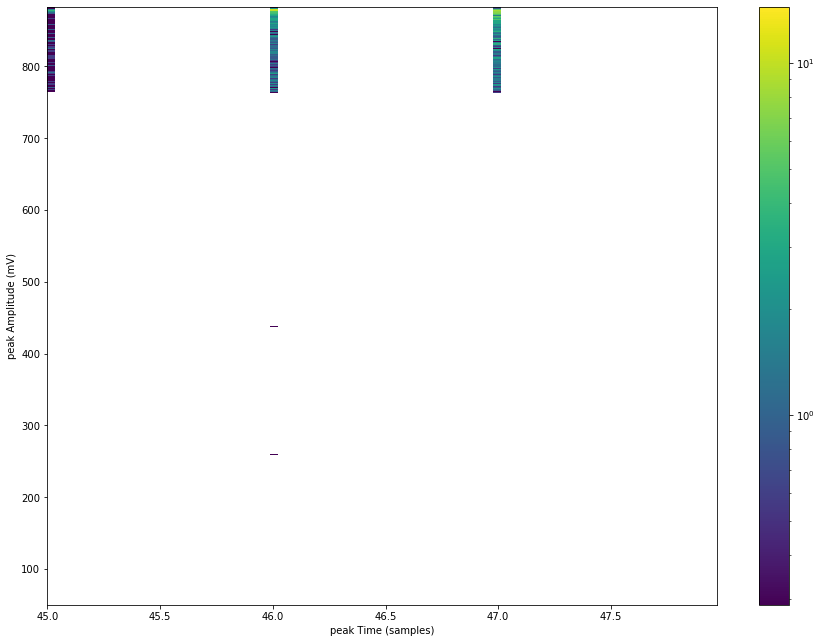

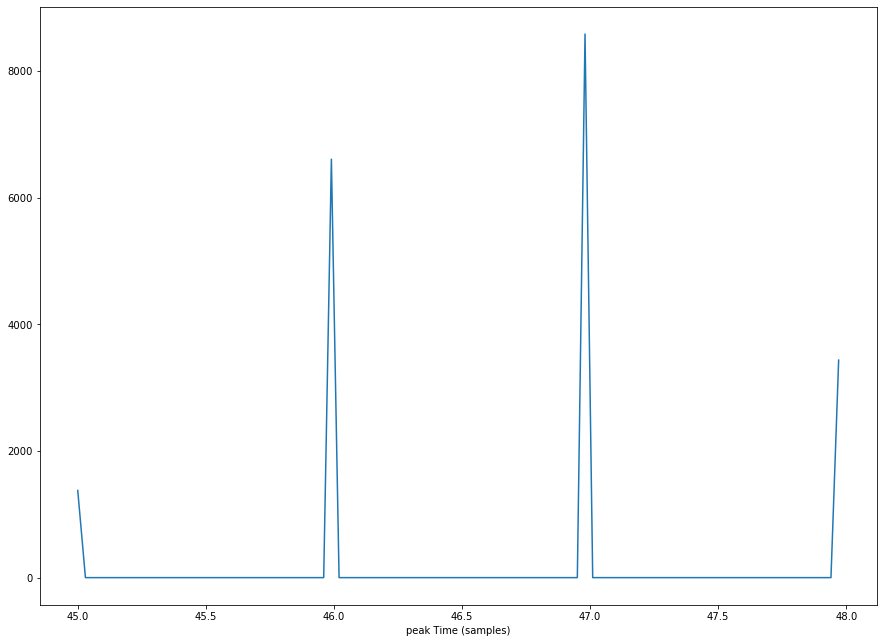

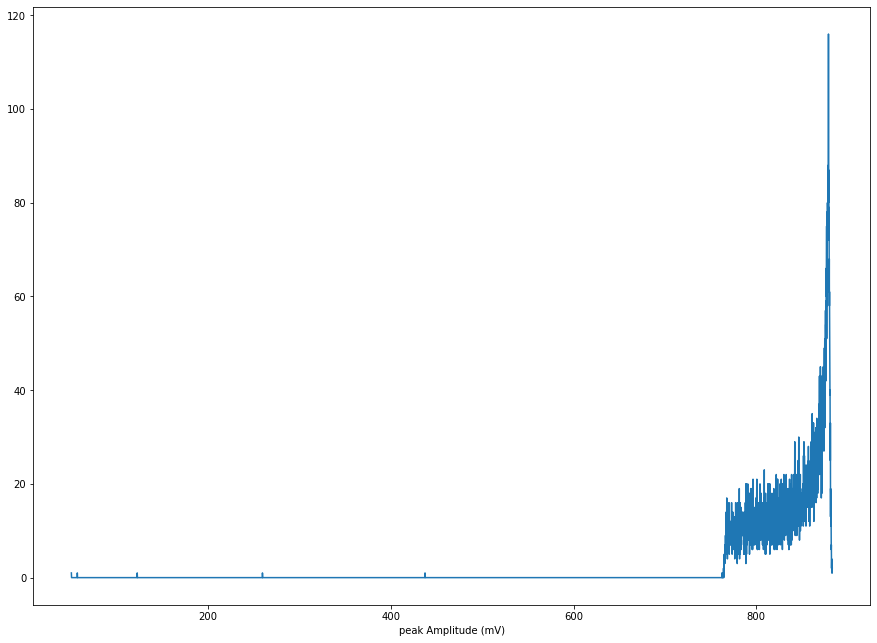

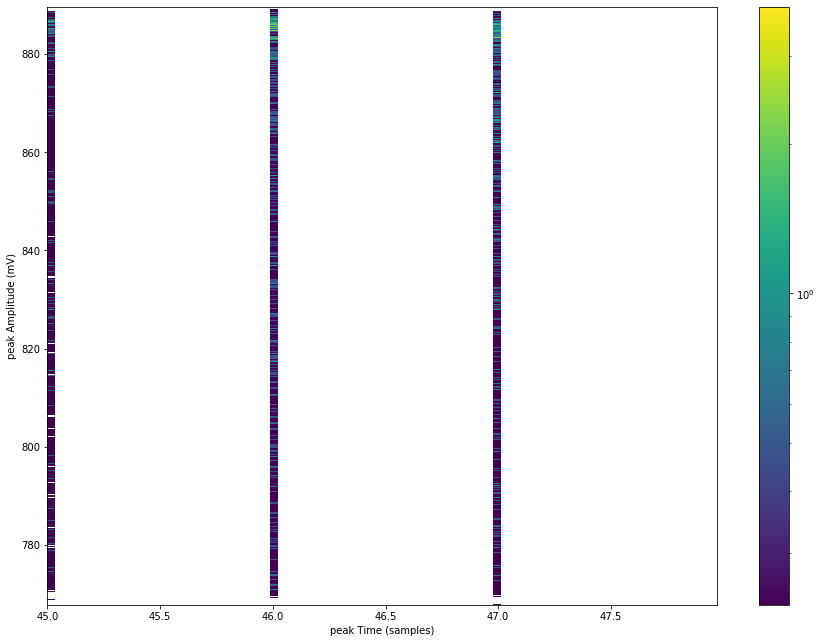

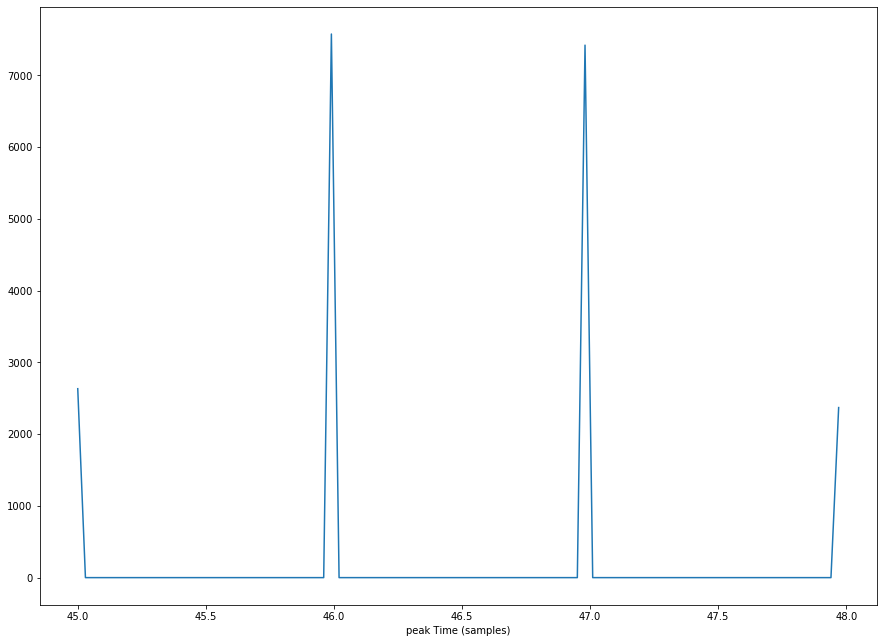

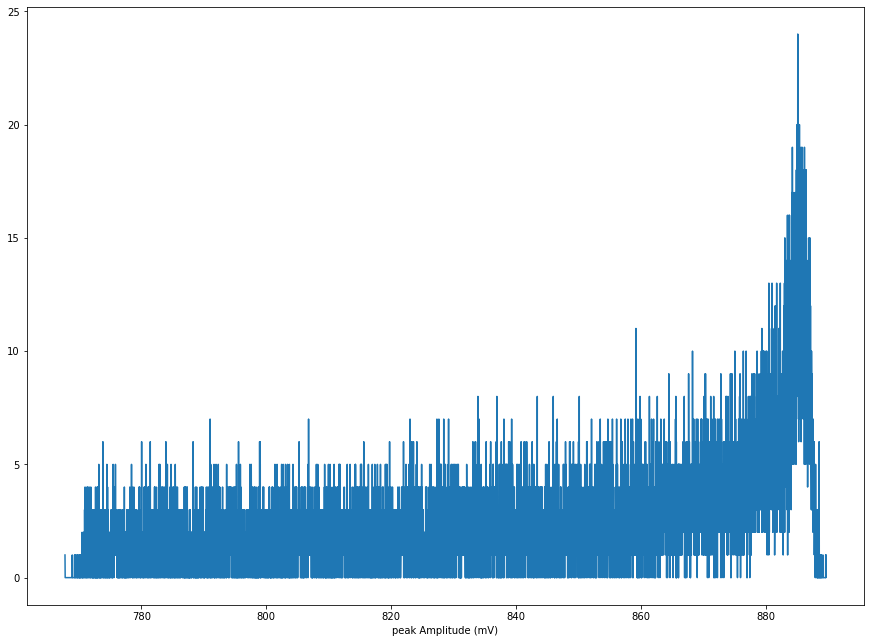

In [7]:
QHists = [tr.extRun(iG,30,10,30,qbins=50) for iG in fWaves]
Gcurve = np.array([QHists[iG][1][np.argmax(QHists[iG][0])] for iG in range(len(Gains))])

Text(0, 0.5, 'Q [pC]')

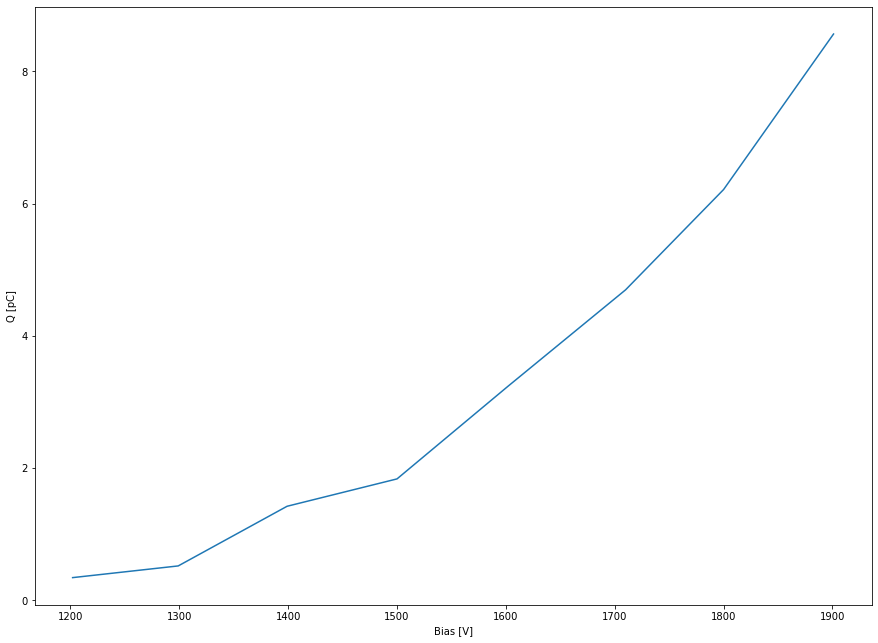

In [8]:
plt.plot(Gains,Gcurve)
#plt.yscale('log')
#plt.xlim(-2,10)
plt.xlabel('Bias [V]')
plt.ylabel('Q [pC]')

In [9]:
QScale = Gcurve[5]/SPE1710
QScale

4.740941013809278

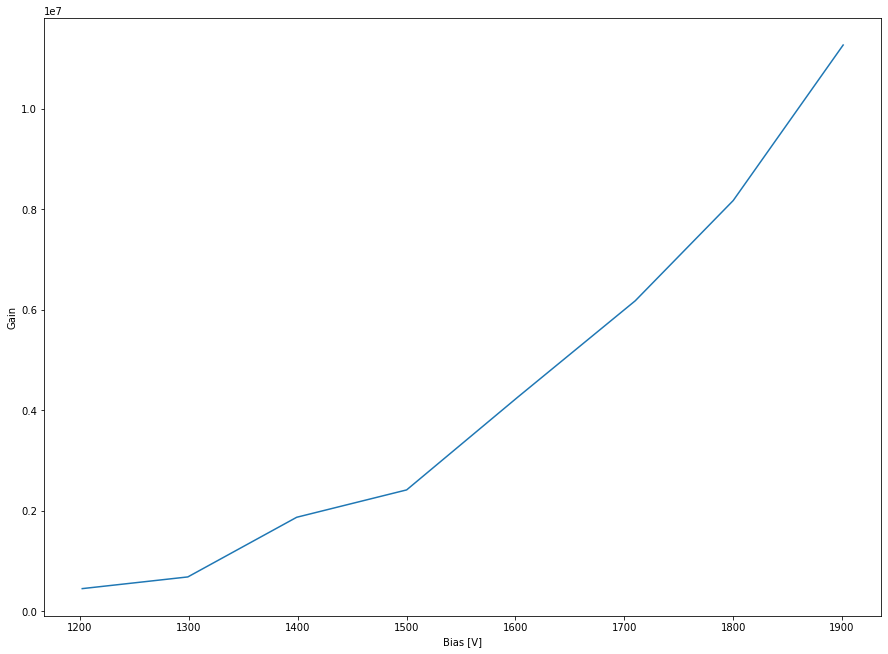

In [13]:
plt.plot(Gains,Gcurve/(QScale*1.6022e-7))
#plt.yscale('log')
#plt.xlim(-2,10)
plt.xlabel('Bias [V]')
plt.ylabel('Gain')
plt.savefig("GainCurve.png")

<Figure size 1080x792 with 0 Axes>